In [1]:
#Importing prereq libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import mlflow
import mlflow.sklearn

In [2]:
# Load dataset
df = pd.read_csv(r"C:\MLCourse\customer_churn_mlops\data\WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Quick check
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Clean and prepare raw data
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

df.drop('customerID', axis=1, inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Splitting and encoding(train_test_split)
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"✅ Cleaned shape: {df.shape}")
print(f"Churn distribution:\n{df['Churn'].value_counts()}")
print(f"Churn rate: {df['Churn'].mean():.2%}")

✅ Cleaned shape: (7043, 20)
Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%


In [4]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5634, 19)
Test shape: (1409, 19)


In [5]:
# Model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Set MLflow experiment
mlflow.set_experiment("customer_churn_prediction_ARTIFACTS")

# Define models and their hyperparameters
models = {
    "logistic_regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "classifier__C": [0.1, 1.0, 10.0],
            "classifier__penalty": ['l2'],
            "classifier__class_weight": ['balanced', None]
        }
    },
    "random_forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [10, 20, None],
            "classifier__min_samples_split": [2, 5],
            "classifier__class_weight": ['balanced', None]
        }
    },
    "gradient_boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__learning_rate": [0.01, 0.1],
            "classifier__max_depth": [3, 5],
            "classifier__subsample": [0.8, 1.0]
        }
    },
    "xgboost": {
        "model": XGBClassifier(random_state=42, eval_metric='logloss'),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__learning_rate": [0.01, 0.1],
            "classifier__max_depth": [3, 5, 7],
            "classifier__scale_pos_weight": [1, 3]  # for imbalanced data
        }
    }
}

# Store results for comparison
results = []

# Train and evaluate each model
for model_name, model_config in models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*60}")
    
    with mlflow.start_run(run_name=f"{model_name}_with_tuning"):
        # Create pipeline
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", model_config["model"])
        ])
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(
            pipeline,
            model_config["params"],
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )
        
        # Train model
        grid_search.fit(X_train, y_train)
        
        # Best model
        best_model = grid_search.best_estimator_
        
        # Predict
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Evaluate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Print results
        print(f"\nBest Parameters: {grid_search.best_params_}")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {auc:.4f}")
        
        # Log to MLflow
        mlflow.log_param("model_type", model_name)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", auc)
        mlflow.log_metric("cv_best_score", grid_search.best_score_)
        
        # Log model
        mlflow.sklearn.log_model(best_model, "model")
        
        # Store results
        results.append({
            "model": model_name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "roc_auc": auc,
            "best_params": grid_search.best_params_
        })

# Comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1_score', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON (Sorted by F1 Score)")
print("="*60)
print(results_df[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].to_string(index=False))
print("\n" + "="*60)
print(f"BEST MODEL: {results_df.iloc[0]['model'].upper()}")
print(f"F1 Score: {results_df.iloc[0]['f1_score']:.4f}")
print("="*60)

# Log comparison as artifact
with mlflow.start_run(run_name="model_comparison"):
    results_df.to_csv("model_comparison.csv", index=False)
    mlflow.log_artifact("model_comparison.csv")
    mlflow.log_metric("best_f1_score", results_df.iloc[0]['f1_score'])
    mlflow.log_param("best_model", results_df.iloc[0]['model'])

2025/10/13 01:25:27 INFO mlflow.tracking.fluent: Experiment with name 'customer_churn_prediction_ARTIFACTS' does not exist. Creating a new experiment.



Training LOGISTIC_REGRESSION
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
Accuracy:  0.7523
Precision: 0.5202
Recall:    0.8284
F1 Score:  0.6391
ROC AUC:   0.8620


2025/10/13 01:25:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 01:25:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training RANDOM_FOREST
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/10/13 01:26:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Accuracy:  0.7807
Precision: 0.5645
Recall:    0.7507
F1 Score:  0.6444
ROC AUC:   0.8608


2025/10/13 01:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training GRADIENT_BOOSTING
Fitting 5 folds for each of 16 candidates, totalling 80 fits


2025/10/13 01:26:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Accuracy:  0.8169
Precision: 0.6861
Recall:    0.5684
F1 Score:  0.6217
ROC AUC:   0.8593


2025/10/13 01:26:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training XGBOOST
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 3}
Accuracy:  0.7544
Precision: 0.5222
Recall:    0.8525
F1 Score:  0.6477
ROC AUC:   0.8590


2025/10/13 01:27:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 01:27:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



MODEL COMPARISON (Sorted by F1 Score)
              model  accuracy  precision   recall  f1_score  roc_auc
            xgboost  0.754436   0.522167 0.852547  0.647658 0.858952
      random_forest  0.780696   0.564516 0.750670  0.644419 0.860781
logistic_regression  0.752307   0.520202 0.828418  0.639090 0.861989
  gradient_boosting  0.816891   0.686084 0.568365  0.621701 0.859318

BEST MODEL: XGBOOST
F1 Score: 0.6477


THRESHOLD OPTIMIZATION

Optimal Threshold: 0.5776
F1 at Optimal: 0.6562
Precision at Optimal: 0.5635
Recall at Optimal: 0.7855

COMPARISON: Default vs Optimal Threshold

--- Default Threshold (0.5) ---
Accuracy:  0.7544
Precision: 0.5222
Recall:    0.8525
F1 Score:  0.6477

--- Optimal Threshold (0.5776) ---
Accuracy:  0.7821
Precision: 0.5635
Recall:    0.7855
F1 Score:  0.6562

Improvement: +1.32%

CONFUSION MATRICES

Default Threshold (0.5):
True Neg:  745 | False Pos:  291
False Neg:   55 | True Pos:  318

Optimal Threshold (0.5776):
True Neg:  809 | False Pos:  227
False Neg:   80 | True Pos:  293

✅ Visualization saved as 'threshold_optimization.png'


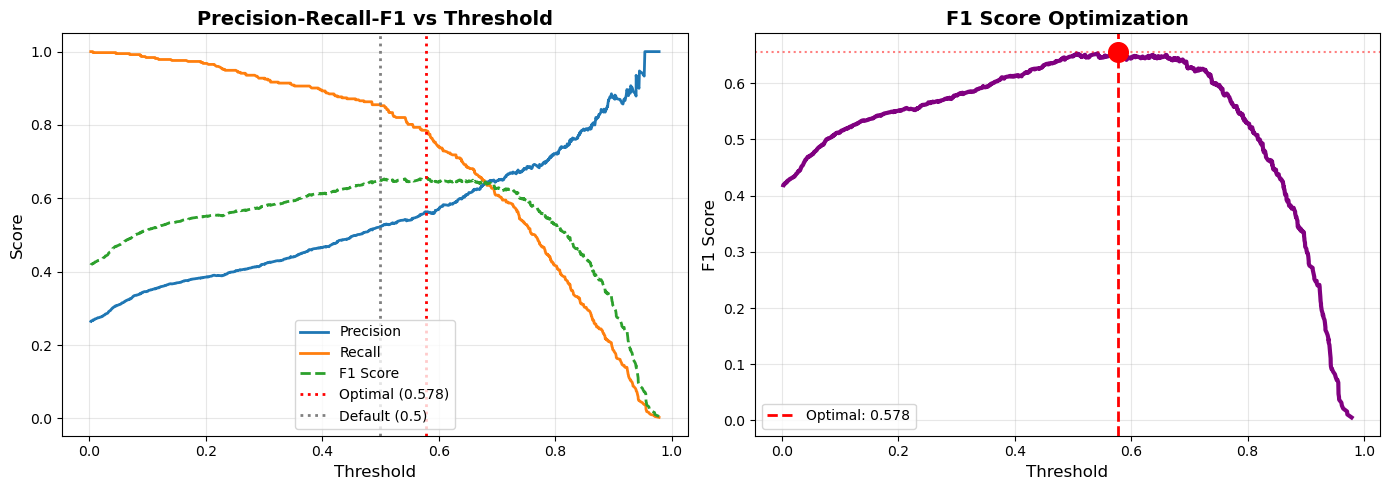


SUMMARY TABLE
 Threshold  Accuracy  Precision   Recall  F1_Score
  0.500000  0.754436   0.522167 0.852547  0.647658
  0.577574  0.782115   0.563462 0.785523  0.656215

BUSINESS INTERPRETATION

Out of 373 actual churners:
  Default (0.5): Caught 318 (85.3%)
  Optimal (0.578): Caught 293 (78.6%)
  Difference: -25 more churners caught!

False alarms (contacted customers who wouldn't churn):
  Default (0.5): 291
  Optimal (0.578): 227
  Difference: -64 false alarms

💡 RECOMMENDATION
Use threshold = 0.5776 instead of default 0.5
Expected F1 improvement: +1.32%


In [7]:

# THRESHOLD OPTIMIZATION ON BASELINE MODEL

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
import pandas as pd
import mlflow

# Loading bext xgb model
model_uri = "runs:/a47bc908ab7c498fa42063cc31fffb1c/model"  
best_xgboost_model = mlflow.sklearn.load_model(model_uri)

# Prediction with model
y_pred_proba = best_xgboost_model.predict_proba(X_test)[:, 1]

print("="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)


# Get probability predictions
y_pred_proba = best_xgboost_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1 scores for each threshold
f1_scores = []
for i in range(len(thresholds)):
    f1 = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"F1 at Optimal: {optimal_f1:.4f}")
print(f"Precision at Optimal: {precisions[optimal_idx]:.4f}")
print(f"Recall at Optimal: {recalls[optimal_idx]:.4f}")

# Compare with default threshold (0.5)
y_pred_default = (y_pred_proba >= 0.5).astype(int)
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score

print("\n" + "="*60)
print("COMPARISON: Default vs Optimal Threshold")
print("="*60)

print("\n--- Default Threshold (0.5) ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_default):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_default):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_default):.4f}")

print(f"\n--- Optimal Threshold ({optimal_threshold:.4f}) ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_optimal):.4f}")

improvement = (f1_score(y_test, y_pred_optimal) - f1_score(y_test, y_pred_default)) / f1_score(y_test, y_pred_default) * 100
print(f"\nImprovement: {improvement:+.2f}%")

# Confusion matrices
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

cm_default = confusion_matrix(y_test, y_pred_default)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print("\nDefault Threshold (0.5):")
print(f"True Neg: {cm_default[0,0]:4d} | False Pos: {cm_default[0,1]:4d}")
print(f"False Neg: {cm_default[1,0]:4d} | True Pos: {cm_default[1,1]:4d}")

print(f"\nOptimal Threshold ({optimal_threshold:.4f}):")
print(f"True Neg: {cm_optimal[0,0]:4d} | False Pos: {cm_optimal[0,1]:4d}")
print(f"False Neg: {cm_optimal[1,0]:4d} | True Pos: {cm_optimal[1,1]:4d}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision-Recall-F1 vs Threshold
axes[0].plot(thresholds, precisions[:-1], label='Precision', linewidth=2)
axes[0].plot(thresholds, recalls[:-1], label='Recall', linewidth=2)
axes[0].plot(thresholds, f1_scores, label='F1 Score', linewidth=2, linestyle='--')
axes[0].axvline(optimal_threshold, color='red', linestyle=':', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
axes[0].axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.5)')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Precision-Recall-F1 vs Threshold', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: F1 Score zoom
axes[1].plot(thresholds, f1_scores, linewidth=3, color='purple')
axes[1].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal: {optimal_threshold:.3f}')
axes[1].axhline(optimal_f1, color='red', linestyle=':', alpha=0.5)
axes[1].scatter([optimal_threshold], [optimal_f1], color='red', s=200, zorder=5)
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('F1 Score Optimization', fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved as 'threshold_optimization.png'")
plt.show()

# Create summary dataframe
threshold_results = pd.DataFrame({
    'Threshold': [0.5, optimal_threshold],
    'Accuracy': [accuracy_score(y_test, y_pred_default), accuracy_score(y_test, y_pred_optimal)],
    'Precision': [precision_score(y_test, y_pred_default), precision_score(y_test, y_pred_optimal)],
    'Recall': [recall_score(y_test, y_pred_default), recall_score(y_test, y_pred_optimal)],
    'F1_Score': [f1_score(y_test, y_pred_default), f1_score(y_test, y_pred_optimal)]
})

print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
print(threshold_results.to_string(index=False))

# Business interpretation
print("\n" + "="*60)
print("BUSINESS INTERPRETATION")
print("="*60)

churn_caught_default = cm_default[1,1]
churn_caught_optimal = cm_optimal[1,1]
total_churners = cm_default[1,0] + cm_default[1,1]

false_alarms_default = cm_default[0,1]
false_alarms_optimal = cm_optimal[0,1]

print(f"\nOut of {total_churners} actual churners:")
print(f"  Default (0.5): Caught {churn_caught_default} ({churn_caught_default/total_churners*100:.1f}%)")
print(f"  Optimal ({optimal_threshold:.3f}): Caught {churn_caught_optimal} ({churn_caught_optimal/total_churners*100:.1f}%)")
print(f"  Difference: {churn_caught_optimal - churn_caught_default:+d} more churners caught!")

print(f"\nFalse alarms (contacted customers who wouldn't churn):")
print(f"  Default (0.5): {false_alarms_default}")
print(f"  Optimal ({optimal_threshold:.3f}): {false_alarms_optimal}")
print(f"  Difference: {false_alarms_optimal - false_alarms_default:+d} false alarms")

print("\n" + "="*60)
print("💡 RECOMMENDATION")
print("="*60)
print(f"Use threshold = {optimal_threshold:.4f} instead of default 0.5")
print(f"Expected F1 improvement: {improvement:+.2f}%")
print("="*60)